In [1]:
### PREAMBLE
# Chapter 4 - Adversarial training, solving the outer minimization
# linear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## From adversarial examples to training robust models

In the previous chapter, we focused on methods for solving the inner maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
We covered three main techniques for doing this: local gradient-based search (providing a lower bound on the objective), exact combinatorial optimization (exactly solving the objective), and convex relaxations (providing a provable upper bound on the objective).

In this Chapter, we return to the min-max problem that we posed in the very first chapter, which corresponds to the task of training a model that is robust to adversarial attacks; in other words, no matter what attack an adversary uses, we want to have a model that performs well (especially if we don't know the precise strategy that the attacker is going to use; more on this in a second).  That is, given some set of input/ouptput pairs $S$, we want to solve the outer minimization problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$ (this was implicitly assumed throughout the entire previous section), and that they get to specialize their attack to whatever parameters we have chosen in the outer maximization.  The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model.  Of course, in practice we may want to make assumptions about the power of the adversary: maybe (or maybe not) it is reasonable to assume they could not solve the integer programs for models that are too large.  But it can be difficult to pin down a precise definition of what we mean by the "power" of the adversary, so extra care should be taken in evaluating models against possible "realistic" adversaries.

The good news, in some sense, is that we already did a lot of the hard work in adversarial training, when we described various ways to approximately solve the inner maximization problem.  For each of the three methods for solving this inner problem (1) lower bounding via local search, 2) exact solutions via combinator optimziation, and 3) upper bounds via convex relaxations), there would be an equivalent manner for training an adversarially robust system.  However, the second option here is not tennable in practice; solving integer programs is already extremely time consuing, and further integrating this into a training procedure (where effectively, we need to compute the solution to an integer program, with the number of variables equal to the number of hidden units in the net, one for _each pass over each example in the dataset_.  This is not a practical approach, and thus we will leave out the possibility of integrating exact combinatorial solution methods into the training procedure.  These leaves us with two choices:

1. Using lower bounds, and examples constructed via local search methods, to train an (empirically) adversarially robust classifier.
2. Using convex upper bounds, to train a provably robust classifier.

There are trade-offs between both approaches here: while the first method may seem less desireable, it will turn out that the first approach empircally creates strong models (with empircally better "clean" performance as well as better robust performance for the best attacks that we can produce.  Thus, both sets of strategies are important to consider in determining how best to build adversarially robust models.

## Adversarial training with adversarial examples

Perhaps the simplest strategy for training an adversarially robust model is also the one which seems most intuitive.  The basic idea (which originally was referred to as "adversarial training" in the machine learning literature, though is also basic technique from robust optimization when viewed through this lense) is to simply create and then incorporate adversarial examples into the training process.  In other words, since we know that "standard" training creates networks that are succeptible to adversarial examples, let's just _also_ train on a few adversarial examples.

Of course, the question arises as to _which_ adversarial examples we should train on.  To get at an answer to this question, let's return to a topic we touch on briefly in the introductory chapter.  Supposing we generally want to optimize the min-max objective 
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
using gradient descent, how do we do so?  If we want to simply optimize $\theta$ by stochastic gradient descent, this would simply involve computing repeatedly computing the gradient with respect to $\theta$ for the loss function on some minibatch, and taking a step in this negative direction.  That is, we want to repeat the update
\begin{equation}
\theta := \theta - \alpha \frac{1}{|B|} \sum_{x,y \in B} \nabla_\theta \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

How do we go about computing this inner gradient?  As we mentioned in the first chapter, the answer is given by Danskin's Theorem, which states that to compute the (sub)gradient of a function containing a max term, we need to simply 1) find the maximum, and 2) compute the normal gradient evaluated at this point.  In other words, the relevant gradient is given by
\begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
\nabla_\theta \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) = \nabla_\theta \ell(h_\theta(x + \delta^\star(x)), y)
\end{equation}
where 
\begin{equation}
\delta^\star(x) = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

Note however, that Danskin's theorem only technically applies to the case where we are able to compute the maximum exactly.  As we learned from the previous section, finding the maximum exactly is not an easy task.  And it is very difficult to say anything formally about the nature of the gradient if we do not solve the problem optimally.  Nonetheless, what we find in practice is the following: the "quality" of the robust gradient descent procedure is tied directly to how well we are able to perform the maximization.  In other words, the better job we do of solving the inner maximization problem, the closer it seems that Danskin's theorem starts to hold.  In other words, _the key aspects of adversarial training is incorporate a strong attack into the inner maximization procedure_.  And projected gradient descent approaches (again, this included the simple variants like projected steepest descent) are the strongest attack that the community has found.

To recap, our strategy is the following:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \mbox{1. Select minibatch $B$, initialize gradient vector $g := 0$} \\
& \quad \mbox{2. For each $(x,y)$ in $B$:} \\
& \quad \quad \mbox{a. Find an attack perturbation $\delta^\star$ by (approximately) optimizing } \\
& \qquad \qquad \qquad \delta^\star = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) \\
& \quad \quad \mbox{b. Add gradient at $\delta^\star$} \\
& \qquad \qquad \qquad g:= g + \nabla_\theta \ell(h_\theta(x + \delta^\star), y) \\
& \quad \mbox{3. Update parameters $\theta$} \\
& \qquad \qquad \qquad \theta:= \theta - \frac{\alpha}{|B|} g
\end{split}
\end{equation}
Although this procedure approximately optimizes the robust loss, which is exactly the target we would like to optimize, in practice it is common to _also_ include a bit of the standard loss (i.e., also take gradient steps in the original data points), as this tends to also slightly improve the performance of the "standard" error of the task.  It is also common to randomize over the starting positions for PGD, or else there can be issues with the procedure learning loss surface such that the gradients exactly at the same points point in a "shallow" direction, but very nearby there are points that have the more typical steep loss surfaces of deep networks.

Let's see how this all looks in code.  To start with, we're going to clone a bunch of the code we used in the previous chapter, including the procedures for building and training the network and for producing adversarial examples.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [4]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

The only real modification we make is that we modify the adversarial function to also allow for training.

In [5]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

Let's start by training a standard model and evaluating adversarial error.

In [6]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

0.280917	0.032200	0.629900
0.026217	0.019100	0.644000
0.016883	0.017100	0.687300
0.012717	0.015200	0.676500
0.009267	0.013800	0.754000
0.003767	0.011700	0.713900
0.002917	0.011600	0.715900
0.002483	0.012100	0.715700
0.002067	0.011200	0.720700
0.001767	0.011300	0.723500


In [7]:
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

So as we saw before, the clean error is quite low, but the adversarial error is quite high (and actually goes up as we train the model more).  Let's now do the same thing, but with adversarial training.

In [8]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [9]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

0.678483	0.085700	0.207300
0.091700	0.018500	0.053600
0.050233	0.016900	0.044400
0.037933	0.015100	0.042000
0.031283	0.011000	0.031300
0.021200	0.009300	0.029100
0.019200	0.009300	0.029900
0.018450	0.009600	0.027700
0.017767	0.009000	0.028800
0.017383	0.008900	0.028300


In [10]:
model_cnn_robust.load_state_dict(torch.load("model_cnn_robust.pt"))

<All keys matched successfully>

### Evaluating robust models
Ok, so with adversarial training, we are able to get a model that has an error rate of just 2.8%, compared to the 71% that our original model had (and increased test accuracy as well, though this is one are where we want to emphasize that this better clean error is an artifact of the MNIST data set, and not something we expect in general).  This seems like a resounding success!

Let's be very very careful, though.  Whenever we train a network against a _specific_ kind of attack, it's incredibly easy to perform well against that particular attack in the future: in a sense, this is just the standard statement about deep network performance: they are incredibly good at predicting precisely the class of data they were trained against.  What about if we run some other attack, like FGSM?  What if we run PGD for longer? Or with randomization?  Or what if someone in the future comes up with some amazing new optimization procedure that works even better (for attacks within the prescribed norm bound)?

Let's get a sense of this by evaluating our model against some different attacks.  Let's try FGSM first.

In [11]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])

FGSM:  0.0266


Ok, that is good news.  FGSM indeed works worse than even the PGD attack we trained against, because FGSM _is_ really just one step of PGD with a step size of $\alpha = \epsilon$.  So it's not surprising it does worse.  Let's try running PGD for longer.

In [12]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.0284


Also good!  Error increases a little bit, but well within the bounds of what we might think in reasonable (you can try running for longer, and see that it doesn't change much ... the examples have bit the boundaries of the $\ell_\infty$ ball in most cases, and taking more steps doesn't change things).  But what about if we take more steps _with_ a smaller step size, to try to get a more "fine-grained" attack?

In [13]:
print("PGD, small_alpha: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, alpha=0.05)[0])

PGD, small_alpha:  0.0281


Ok, we're getting more confident now.  Let's also add randomization.

In [14]:
print("PGD, randomized: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, 
                                             num_iter=40, randomize=True)[0])

PGD, randomized:  0.0283


Alright, so at this point, we've done enough evaluations that maybe we are confident enough to [put the model online and see if anyone else can actually break it](https://github.com/MadryLab/mnist_challenge) (note: this is not actually the model that was put online, though it was trained in the roughly the same manner).  But we should still probably try some different optimizers, try multiple randomized restarts (like we did in the past section), etc.

**Note:** one evaluation which is _not_ really relevant (except maybe out of curiosity), however, is to evaluate the performance of this robust model under some _other_ perturbation region, say evaluating this $\ell_\infty$ robust model under an $\ell_2$ bounded attack.  The model was trained under one single attack model; of course it will not work well to prevent some completely different attack model.  If one _does_ desire a kind of "generalization" across multiple attack models, then we need to formally define the set of attack models we care about, and train the model over multiple different draws from these attack models.  This is a topic we won't get in to, except to say that for some classes like multiple different norm bounds, it would be easy to extend the approach to simultaneously defend against e.g. $\ell_1$, $\ell_2$, and $\ell_\infty$ attacks, or something like this.  Of course, the _real_ set of attacks we care about (i.e., the set of all images that a human thinks "look reasonably the same") is extremely hard to characterize, and an excellent subject for future work.

### What is happening with these robust models?

So why do these models work well against robust attacks, and why have some other proposed methods for training robust models (in)famously come up short in this regard?  There are likely many answers to this question, but one potential answer can be seen by looking at the loss surface of the trained classifier.  Let's look at a projection of the loss function along two dimensions in the input space (one the direction of the actual gradient, and one a random direction).

In [15]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [16]:
def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))
    
    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))
    
    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @ 
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)


Let's look at the loss surface for the standard network.

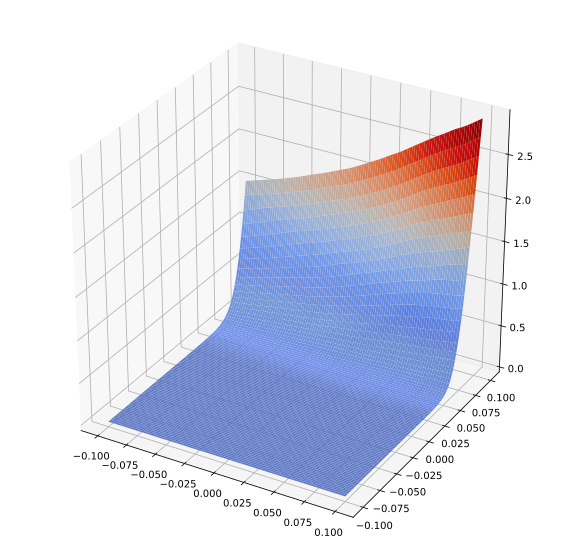

In [17]:
draw_loss(model_cnn, X[0:1], 0.1)

Very quickly the loss increases substantially.  Let's then compare this to the robust model.

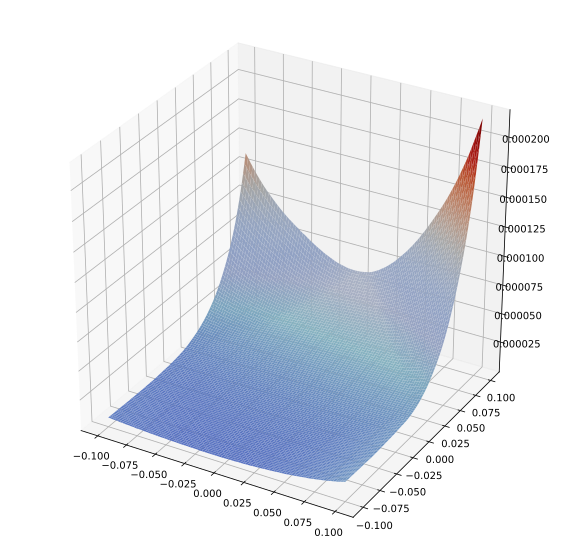

In [18]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

The important point to compare here is the relative $z$ axes (the "bumpiness" in the second figure is just to do this much smaller scale; if put on the same scale the second figure would be completely flat).   The robust model has a loss that is quite flat both in the gradient direction (that is the steeper direction), and in the random direction, whereas the traditionally trained model varies quite rapidly both in the gradient direction and (after moving some in the gradient direction) in the random direction.  Of course, this is no guarantee that there _is_ no direction of steep cost increase, but it at least gives some hint of what may be happening.

In summary, these models trained with PGD-based adversarial training _do_ appear to be genuinely robust, in that the underlying models themselves have smooth loss surfaces, and not by just a "trick" that hides the true direction of cost increase.  Whether more can be said formally about the robustness is a quick that remains to be seen, and a topic of current ongoing research.

## Relaxation-based robust training

As a final piece of the puzzle, let's try to use the convex relaxation methods not just to verify networks, but also to train them.  To see why we might want to do this, we're going to focus here on the interval-based bounds, though all the same factors apply to the linear programming convex relaxation as well, just to a slightly smaller degree (and the methods are much more computationally intensive).

To start, let's consider using our interval bound to try to _verify_ robustness for the empirically robust classifier we just trained.  Remember that a classifier is verified to be robust against an adversarial attack if the optimization objective is positive for _all_ targeted classes.  This is done by the following code (almost entirely copied from the previous chapter, but with an additional routine that computes the verified accuracy over batches).





In [19]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds


def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias
    
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()    


def robust_bound_error(model, X, y, epsilon):
    initial_bound = (X - epsilon, X + epsilon)
    err = 0
    for y0 in range(10):
        C = -torch.eye(10).to(device)
        C[y0,:] += 1
        err += (interval_based_bound(model, C, bounds, y==y0).min(dim=1)[0] < 0).sum().item()
    return err

def epoch_robust_bound(loader, model, epsilon):
    total_err = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        for y0 in range(10):
            lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
            total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
    return total_err / len(loader.dataset)

Let's see what happens if we try to use this bound to see whether we can verify that our robustly trained model _provably_ will be insucceptible to adversarial examples in some cases, rather than just empirically so.

In [22]:
epoch_robust_bound(test_loader, model_cnn_robust, 0.0005)

0.2904

Unfortunately, the interval-based bound is entirely vaccous for our (robustly) trained classifier.  We'll save you the disappointment of checking ever smaller values of $\epsilon$, and just mentioned that in order to get any real verification with this method, we need values of $\epsilon$ less than 0.001.  For example, for $\epsilon = 0.0001$, we finally achieve a "reasonable" bound.

In [23]:
epoch_robust_bound(test_loader, model_cnn_robust, 0.0001)

0.0187

That doesn't seem particularly useful, and indeed, it is a property of virtually all the relaxation-based verification approaches, is that they are vaccuous when evaluated upon a network trained without knowledge of these bounds.  Additionally, these errors tend to accumulate with the depth of the network, precisely because the interval bounds as we have presented them also tend to get looser with each layer of the network (this is why the bounds were not so bad in the previous chapter, when we were applying them to a three-layer network).

### Training using provable criteria

So if the verifiable bounds we get are this loose, even for empirically robust networks, of what value could they be?  It turns out that, perhaps somewhat surprisingly, if we _train_ a network specifically to minimize a loss based upon this upper bound, we get a network where the bounds are meaningful.  This is a somewhat subtle but important point which is worth repeating.  In other words, if we train an _empirically_

To do this, we're going to use the interval bounds to upper bound the cross entropy loss of a classifier, and then minimize this upper bound.  Specifically, if we form a "logit" vector where we replace each entry with the negative value of the objective for a targeted attack, and then take the cross entropy loss of _this_ vector, it functions as a strict upper bound of the original loss.  We can implement this as follows.

In [24]:
def epoch_robust_bound(loader, model, epsilon, opt=None):
    total_err = 0
    total_loss = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        loss = 0
        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        total_loss += loss.item() * X.shape[0]  
        #print(loss.item())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

Finally, let's train our model using this robust loss bound.  Note that training rovably robust models is a bit of a tricky business.  If we start out immediately by trying to train our robust bound with the full $\epsilon=0.1$, the model will collapse to just predicting equal probability for all digits, and will never recover.  Instead, to reliably train such models we need to schedule $\epsilon$ during the training process, starting with a small $\epsilon$ and gradually raising it to the desired level.  The schedule we use below was picked rather randomly, and we can do much better with a bit of tweaking, but it serves our basic purpose.

In [25]:
torch.manual_seed(0)
model_cnn_robust_2 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1, stride=2), nn.ReLU(),
                                   nn.Conv2d(32, 32, 3, padding=1, ), nn.ReLU(),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                   Flatten(),
                                   nn.Linear(7*7*64, 100), nn.ReLU(),
                                   nn.Linear(100, 10)).to(device)

In [26]:
opt = optim.SGD(model_cnn_robust_2.parameters(), lr=1e-1)
eps_schedule = [0.0, 0.0001, 0.001, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.05] + 15*[0.1]

print("Train Eps", "Train Loss*", "Test Err", "Test Robust Err", sep="\t")
for t in range(len(eps_schedule)):
    train_err, train_loss = epoch_robust_bound(train_loader, model_cnn_robust_2, eps_schedule[t], opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust_2)
    adv_err, adv_loss = epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)
    #if t == 4:
    #    for param_group in opt.param_groups:
    #        param_group["lr"] = 1e-2

    print(*("{:.6f}".format(i) for i in (eps_schedule[t], train_loss, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust_2.state_dict(), "model_cnn_robust_2.pt")

Train Eps	Train Loss*	Test Err	Test Robust Err
0.000000	0.841623	0.030900	1.000000
0.000100	0.127609	0.021300	1.000000
0.001000	0.121362	0.018100	1.000000
0.010000	0.355173	0.032000	1.000000
0.010000	0.165142	0.026700	1.000000
0.050000	0.869047	0.078200	0.354600
0.050000	0.427200	0.073000	0.613600
0.050000	0.358997	0.060900	0.235200
0.050000	0.306393	0.053300	0.144400
0.050000	0.279155	0.056100	0.155500
0.100000	0.405840	0.059200	0.111000
0.100000	0.369344	0.060700	0.111300
0.100000	0.351776	0.053400	0.098100
0.100000	0.334682	0.056100	0.104200
0.100000	0.324224	0.052500	0.097500
0.100000	0.315395	0.053900	0.103500
0.100000	0.307975	0.047100	0.089400
0.100000	0.300654	0.048700	0.086400
0.100000	0.294073	0.047400	0.090200
0.100000	0.289331	0.050300	0.091100
0.100000	0.286107	0.048900	0.090600
0.100000	0.280901	0.049000	0.084500
0.100000	0.279113	0.043100	0.083200
0.100000	0.274486	0.048000	0.084400
0.100000	0.271065	0.045300	0.086600


It's not going to set any records, but what we have here is an MNIST model that where _no_ $\ell_\infty$ attack of norm bounded by $\epsilon=0.1$ will _ever_ be able to cause the classifier to experience more than 9.67% error on the test set of MNIST (acheiving a "clean" error of 5.15%).  And just how bad _can_ a real adversarial attack do?  It's of course hard to say for sure, but let's see what PGD does.

In [27]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust_2, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.0699


So somewhere right in the middle.  Note also that training these provably robust models is a challenging task, and a bit of tweaking (even still using interval bounds) can perform quite a bit better.  For now, though, this is sufficient to make our point that we _can_ obtain non-trivial provable bounds for trained networks.

## The long road ahead (a.k.a. leaving MNIST behind)

The presentation here might lead you to believe that robust models are seemingly pretty close to their traditional counterparts (what's a few percentage points here or there).  However, while we hope that we _were_ able to get you excited about the potential of these methods, it's important to emphasize that on large-scale problems we are nowhere _close_ to building robust models that can match standard models in terms of their performance.  Unfortunately, a lot of the apparent strength of these models came from our use of MNIST, where it is particularly easy to create robust 

Even on a dataset like CIFAR10, for example, the best known robust models that can handle a perturbation of $8/255 = 0.031$ color values achieve an (empirical) robust _error_ of of 55%, and the best provably robust models have an error greater than 70%.  On the flipside, the choices we have with regards to training procedures, network architecture, regularization, etc, have barely been touched in the robust optimization context.  All our architecture choices come from what has been best for standard training, but these likely are no longer optimal architectures for robust training.  Finally, as we will highlight in the next chapter, there is substantial benefit to be had from robust models right now, even if true robust performance still remains ellusive.